# Retirement Model

This is a retirement model which models salary with both a constant growth rate for cost of living raises as well as regular salary increases for promotions. The model is broken up into the following sections:

- [**Setup**](#Setup): Runs any imports and other setup
- [**Inputs**](#Inputs): Defines the inputs for the model
- [**Salaries**](#Salaries): Determining the salary in each year, considering cost of living raises and promotions
- [**Wealths**](#Wealths): Determining the wealth in each year, considering a constant savings rate and investment rate
- [**Retirement**](#Retirement): Determines years to retirement from the wealths over time, the main output from the model.
- [**Results Summary**](#Results-Summary): Summarize the results with some visualizations
- [**Sensitivity Analysis**](#Sensitivity-Analysis): Determine how sensitive the years to retirement is to the model inputs

## Setup

Setup for the later calculations are here. The necessary packages are imported.

In [1]:
from dataclasses import dataclass
import pandas as pd
%matplotlib inline
import random
import statsmodels.api as sm

## Inputs

All of the inputs for the model are defined here. A class is constructed to manage the data, and an instance of the class containing the default inputs is created.

In [2]:
@dataclass
class ModelInputs:
    starting_salary: int = 60000
    promos_every_n_years: int = 5
    cost_of_living_raise: float = 0.02
    promo_raise: float = 0.15
    savings_rate: float = 0.25
    interest_rate: float = 0.05
    desired_cash: int = 1500000
        
model_data = ModelInputs()
model_data

ModelInputs(starting_salary=60000, promos_every_n_years=5, cost_of_living_raise=0.02, promo_raise=0.15, savings_rate=0.25, interest_rate=0.05, desired_cash=1500000)

## Salaries

Here the salary for each year is calculated. We assume that the salary grows at a constant rate each year for cost of living raises, and then also every number of years, the salary increases by a further percentage due to a promotion or switching jobs. Based on this assumption, the salary would evolve over time with the following equation:

$$s_t = s_0 (1 + r_{cl})^n (1 + r_p)^p$$

Where:
- $s_t$: Salary at year $t$
- $s_0$: Starting salary (year 0)
- $r_{cl}$: Annual cost of living raise
- $r_p$: Promotion raise
- $p$: Number of promotions

And in Python format:

In [3]:
def salary_at_year(data: ModelInputs, year):
    """
    Gets the salary at a given year from the start of the model based on cost of living raises and regular promotions.
    """
    # Every n years we have a promotion, so dividing the years and taking out the decimals gets the number of promotions
    num_promos = int(year / data.promos_every_n_years)
    
    # This is the formula above implemented in Python
    salary_t = data.starting_salary * (1 + data.cost_of_living_raise) ** year * (1 + data.promo_raise) ** num_promos
    return salary_t

That function will get the salary at a given year, so to get all the salaries we just run it on each year. But we will not know how many years to run as we should run it until the individual is able to retire. So we are just showing the first few salaries for now and will later use this function in the [Wealths](#Wealths) section of the model.

In [4]:
for i in range(6):
    year = i + 1
    salary = salary_at_year(model_data, year)
    print(f'The salary at year {year} is ${salary:,.0f}.')

The salary at year 1 is $61,200.
The salary at year 2 is $62,424.
The salary at year 3 is $63,672.
The salary at year 4 is $64,946.
The salary at year 5 is $76,182.
The salary at year 6 is $77,705.


As expected, with the default inputs, the salary is increasing at 2% per year. Then at year 5, there is a promotion so there is a larger increase in salary.

## Wealths

The wealths portion of the model is concerned with applying the savings rate to the earned salary to calculate the cash saved, accumulating the cash saved over time, and applying the investment rate to the accumulated wealth.

To calculate cash saved, it is simply:

$$c_t = s_t * r_s$$

Where:
- $c_t$: Cash saved during year $t$
- $r_s$: Savings rate

In [5]:
def cash_saved_during_year(data: ModelInputs, year):
    """
    Calculated the cash saved within a given year, by first calculating the salary at that year then applying the 
    savings rate.
    """
    salary = salary_at_year(data, year)
    cash_saved = salary * data.savings_rate
    return cash_saved

To get the wealth at each year, it is just applying the investment return to last year's wealth, then adding this year's cash saved:

$$w_t = w_{t-1} (1 + r_i) + c_t$$
Where:
- $w_t$: Wealth at year $t$
- $r_i$: Investment rate

In [6]:
def wealth_at_year(data: ModelInputs, year, prior_wealth):
    """
    Calculate the accumulated wealth for a given year, based on previous wealth, the investment rate,
    and cash saved during the year.
    """
    cash_saved = cash_saved_during_year(data, year)
    wealth = prior_wealth * (1 + data.interest_rate) + cash_saved
    return wealth

Again, just like in the [Salaries](#Salaries) section, we can now get the output for each year, but we don't know ultimately how many years we will have to run it. That will be determined in the [Retirement](#Retirement) section. So for now, just show the first few years of wealth accumulation:

In [7]:
prior_wealth = 0  # starting with no cash saved
for i in range(6):
    year = i + 1
    wealth = wealth_at_year(model_data, year, prior_wealth)
    print(f'The wealth at year {year} is ${wealth:,.0f}.')
    
    # Set next year's prior wealth to this year's wealth
    prior_wealth = wealth

The wealth at year 1 is $15,300.
The wealth at year 2 is $31,671.
The wealth at year 3 is $49,173.
The wealth at year 4 is $67,868.
The wealth at year 5 is $90,307.
The wealth at year 6 is $114,248.


With default inputs, the wealth is going up by approximately 25% of the salary each year, plus a bit more for investment. Then in year 6 we see a substantially larger increase because the salary is substantially larger due to the promotion. So everything is looking correct.

## Retirement

This section of the model puts everything together to produce the final output of years to retirement. It uses the logic to get the wealths at each year, which in turn uses the logic to the get salary at each year. The wealth at each year is tracked over time until it hits the desired cash. Once the wealth hits the desired cash, the individual is able to retire so that year is returned as the years to retirement.

In [8]:
def years_to_retirement(data: ModelInputs, print_output=True):
    
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    
    year = 0  # will become 1 on first loop
    
    if print_output:
        print('Wealths over time:') # \n makes a blank line in the output.
    while wealth < data.desired_cash:
        year = year + 1
        wealth = wealth_at_year(data, year, prior_wealth)
        if print_output:
            print(f'The wealth at year {year} is ${wealth:,.0f}.')

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
    # Now we have exited the while loop, so wealth must be >= desired_cash. Whatever last year was set
    # is the years to retirement.
    if print_output:
        print(f'\nRetirement:\nIt will take {year} years to retire.')  # \n makes a blank line in the output.
    return year

With the default inputs:

In [9]:
years = years_to_retirement(model_data)

Wealths over time:
The wealth at year 1 is $15,300.
The wealth at year 2 is $31,671.
The wealth at year 3 is $49,173.
The wealth at year 4 is $67,868.
The wealth at year 5 is $90,307.
The wealth at year 6 is $114,248.
The wealth at year 7 is $139,775.
The wealth at year 8 is $166,975.
The wealth at year 9 is $195,939.
The wealth at year 10 is $229,918.
The wealth at year 11 is $266,080.
The wealth at year 12 is $304,542.
The wealth at year 13 is $345,431.
The wealth at year 14 is $388,878.
The wealth at year 15 is $439,025.
The wealth at year 16 is $492,294.
The wealth at year 17 is $548,853.
The wealth at year 18 is $608,878.
The wealth at year 19 is $672,557.
The wealth at year 20 is $745,168.
The wealth at year 21 is $822,190.
The wealth at year 22 is $903,859.
The wealth at year 23 is $990,422.
The wealth at year 24 is $1,082,140.
The wealth at year 25 is $1,185,745.
The wealth at year 26 is $1,295,520.
The wealth at year 27 is $1,411,793.
The wealth at year 28 is $1,534,910.

Reti

# Results Summary

## Put Results in a Table

Now I will visualize the salaries and wealths over time. First create a function which runs the model to put these results in a DataFrame.

In [10]:
def get_salaries_wealths_df(data):
    """
    Runs the retirement model, collecting salary and wealth information year by year and storing
    into a DataFrame for further analysis.
    """
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    
    year = 0  # will become 1 on first loop
    
    df_data_tups = []
    while wealth < data.desired_cash:
        year = year + 1
        salary = salary_at_year(data, year)
        wealth = wealth_at_year(data, year, prior_wealth)

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
        # Save the results in a tuple for later building the DataFrame
        df_data_tups.append((year, salary, wealth))
        
    # Now we have exited the while loop, so wealth must be >= desired_cash
    
    # Now create the DataFrame
    df = pd.DataFrame(df_data_tups, columns=['Year', 'Salary', 'Wealth'])
    
    return df

Also set up a function which formats the `DataFrame` for display.

In [11]:
def styled_salaries_wealths(df):
    return df.style.format({
        'Salary': '${:,.2f}',
        'Wealth': '${:,.2f}'
    })

Now call the function to save the results into the `DataFrame`.

In [12]:
df = get_salaries_wealths_df(model_data)
styled_salaries_wealths(df)

,Year,Salary,Wealth
0,1,"$61,200.00","$15,300.00"
1,2,"$62,424.00","$31,671.00"
2,3,"$63,672.48","$49,172.67"
3,4,"$64,945.93","$67,867.79"
4,5,"$76,181.58","$90,306.57"
5,6,"$77,705.21","$114,248.20"
6,7,"$79,259.31","$139,775.44"
7,8,"$80,844.50","$166,975.33"
8,9,"$82,461.39","$195,939.45"
9,10,"$96,727.21","$229,918.22"


## Plot Results

Now I will visualize the salaries and wealths over time.

### Salaries over Time

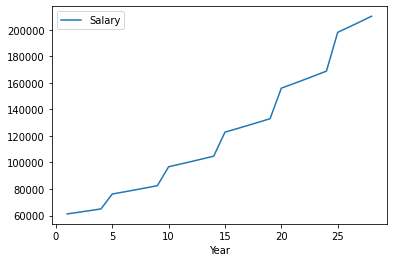

In [13]:
df.plot.line(x='Year', y='Salary')

### Wealths over Time

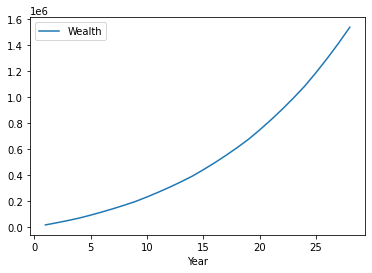

In [14]:
df.plot.line(x='Year', y='Wealth')

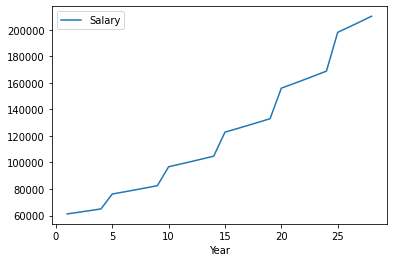

In [15]:
df.plot.line(x='Year', y='Salary')

# Monte Carlo Simulations

The goal with these simulations is to evaluate the probabilities of different years to retirement and also get a better understanding of how each input affects years to retirement, once all the inputs are changing.

## Monte Carlo Setup

First, I will create a new `dataclass` which captures the new model inputs, which are the standard deviations of each of the inputs, as well as the number of iterations. I will use the existing inputs as the means of each input.

> Note: The existing `ModelInputs` will still be used, now these two `dataclass`es work together.

In [16]:
@dataclass
class SimluationInputs:
    n_iterations: int = 10000
    starting_salary_std: int = 10000
    promos_every_n_years_std: int = 1.5
    cost_of_living_raise_std: float = 0.005
    promo_raise_std: float = 0.05
    savings_rate_std: float = 0.07
    interest_rate_std: float = 0.01
        
sim_data = SimluationInputs()

## A Single Simulation Run

Now I will create a functions that picks values of the main model inputs from normal distributions, then runs the model and returns the inputs as well as the years to retirement.

I will need to filter out any nonsensical values in the simulation. For each of the inputs, if it drops below zero, I will draw another input.

In [17]:
def random_normal_positive(mean, std):
    """
    This function keeps drawing random numbers from a normal distribution until it gets a positive number,
    then it returns that number.
    """
    drawn_value = -1  # initialize to some negative number so that the while loop will start
    while drawn_value < 0:
        drawn_value = random.normalvariate(mean, std)
    return drawn_value

def years_to_retirement_simulation_inputs(data, sim_data):
    """
    Randomly picks values from normal distributions for:
    - starting salary 
    - promotions every N years
    - cost of living raise
    - promotion raise
    - savings rate
    - interest rate
    
    These inputs are drawn based on using the ModelInputs values
    as means, and the _std values in SimulationInputs as standard deviations.
    
    Additionally, if any drawn value is zero or below, it will be drawn again.
    """
    starting_salary = random_normal_positive(data.starting_salary, sim_data.starting_salary_std)
    promos_every_n_years = random_normal_positive(data.promos_every_n_years, sim_data.promos_every_n_years_std)
    cost_of_living_raise = random_normal_positive(data.cost_of_living_raise, sim_data.cost_of_living_raise_std)
    promo_raise = random_normal_positive(data.promo_raise, sim_data.promo_raise_std)
    savings_rate = random_normal_positive(data.savings_rate, sim_data.savings_rate_std)
    interest_rate = random_normal_positive(data.interest_rate, sim_data.interest_rate_std)
    
    return (
        starting_salary,
        promos_every_n_years,
        cost_of_living_raise,
        promo_raise,
        savings_rate,
        interest_rate,
    )
    

In [18]:
def years_to_retirement_single_simulation(data, sim_data):
    """
    Runs a single Monte Carlo simulation of the years to retirement model.
    
    Uses years_to_retirement_simulation_inputs
    """
    # Draw values of inputs from normal distributions
    (
        starting_salary,
        promos_every_n_years,
        cost_of_living_raise,
        promo_raise,
        savings_rate,
        interest_rate,
    ) = years_to_retirement_simulation_inputs(data, sim_data)
    
    # Construct model inputs
    new_data = ModelInputs(
        starting_salary=starting_salary,
        promos_every_n_years=promos_every_n_years,
        cost_of_living_raise=cost_of_living_raise,
        promo_raise=promo_raise,
        savings_rate=savings_rate,
        interest_rate=interest_rate,
    )

    # Run model
    ytr = years_to_retirement(new_data, print_output=False)
    
    return (
        starting_salary,
        promos_every_n_years,
        cost_of_living_raise,
        promo_raise,
        savings_rate,
        interest_rate,
        ytr
    )

Running the following cell runs the simulation once. Running it multiple times will show that it is indeed randomized.

In [19]:
years_to_retirement_single_simulation(model_data, sim_data)

(51867.205737179494,
 6.069297565176917,
 0.020743034123798545,
 0.12221189149628771,
 0.18638719069391288,
 0.02951031336500529,
 41)

## Running the Full Monte Carlo Simulation

Now I will write a function that runs the simulations for the number of iterations in the simulation data, and outputs a DataFrame for analysis and visualization.

In [20]:
def years_to_retirement_mc(data, sim_data):
    """
    Runs the full Monte Carlo simulation using years_to_retirement_single_simulation for 
    the n_iterations in the SimulationData.
    
    Outputs a DataFrame containing the inputs values as well as the years to retirement.
    """
    all_results = [years_to_retirement_single_simulation(data, sim_data) for i in range(sim_data.n_iterations)]
    df = pd.DataFrame(
        all_results,
        columns=[
            'Starting Salary', 
            'Promotions Every $N$ Years', 
            'Cost of Living Raise', 
            'Promotion Raise', 
            'Savings Rate', 
            'Interest Rate',
            'Years to Retirement'
        ]
    )
    return df


Now actually run the simulation with the full number of iterations.

In [21]:
df = years_to_retirement_mc(model_data, sim_data)

## Style `DataFrame`

I'll add a function which styles the inputs and years to retirement `DataFrame` so the results can be shown.

In [22]:
def styled_df(df):
    """
    Styles DataFrames containing the inputs and years to retirement.
    """
    return df.style.format({
        'Starting Salary': '${:,.0f}', 
        'Promotions Every $N$ Years': '{:.1f}', 
        'Cost of Living Raise': '{:.2%}', 
        'Promotion Raise': '{:.2%}', 
        'Savings Rate': '{:.2%}', 
        'Interest Rate': '{:.2%}',
        'Years to Retirement': '{:.0f}'
    }).background_gradient(cmap='RdYlGn_r', subset='Years to Retirement')

Also show the number of simulations.

In [23]:
print(f'{len(df)} simulations were run.')

10000 simulations were run.


## Visualize Results

### Example Results

In [24]:
styled_df(df.head())

,Starting Salary,Promotions Every $N$ Years,Cost of Living Raise,Promotion Raise,Savings Rate,Interest Rate,Years to Retirement
0,"$54,836",5.2,1.42%,16.38%,29.22%,4.16%,30
1,"$58,694",5.5,1.89%,12.40%,32.41%,4.91%,27
2,"$74,040",5.4,2.21%,17.98%,30.56%,4.14%,24
3,"$63,114",5.0,0.88%,14.29%,32.00%,6.04%,25
4,"$73,683",5.0,2.63%,14.10%,14.27%,5.18%,31


### Years to Retirement Distribution

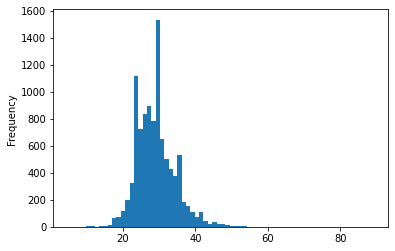

In [25]:
df['Years to Retirement'].plot.hist(bins=70)

### Inputs and Years to Retirement Probability Table

In [26]:
quants = df.quantile([i / 20 for i in range(1, 20)])
styled_df(quants)

,Starting Salary,Promotions Every $N$ Years,Cost of Living Raise,Promotion Raise,Savings Rate,Interest Rate,Years to Retirement
0.05,"$43,733",2.6,1.19%,6.75%,13.46%,3.31%,22
0.1,"$47,325",3.1,1.36%,8.53%,15.79%,3.70%,23
0.15,"$49,814",3.5,1.48%,9.77%,17.65%,3.94%,24
0.2,"$51,829",3.7,1.58%,10.76%,19.04%,4.14%,25
0.25,"$53,526",4.0,1.66%,11.64%,20.26%,4.31%,25
0.3,"$54,975",4.2,1.74%,12.29%,21.30%,4.46%,26
0.35,"$56,371",4.4,1.81%,13.01%,22.35%,4.60%,27
0.4,"$57,706",4.6,1.88%,13.68%,23.35%,4.73%,27
0.45,"$58,984",4.8,1.94%,14.39%,24.24%,4.87%,28
0.5,"$60,120",5.0,2.01%,15.03%,25.15%,4.99%,28


### Plots of Inputs vs. Years to Retirement 

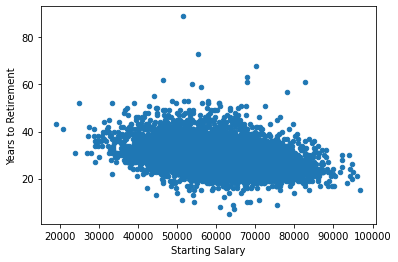

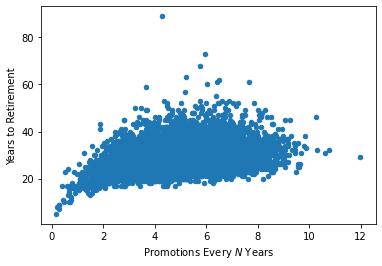

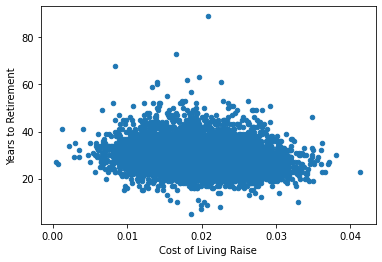

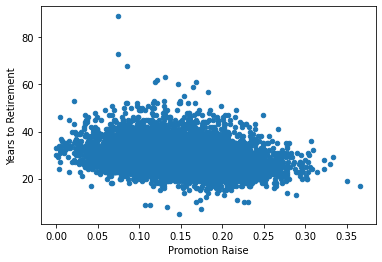

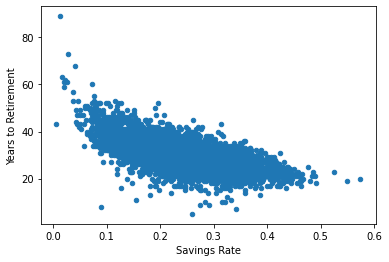

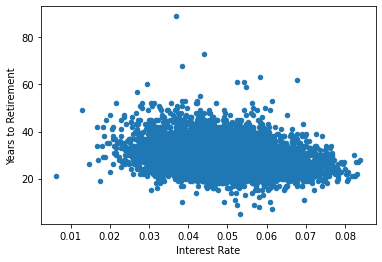

In [31]:
input_cols = [
    'Starting Salary', 
    'Promotions Every $N$ Years', 
    'Cost of Living Raise', 
    'Promotion Raise', 
    'Savings Rate', 
    'Interest Rate',
]

for col in input_cols:
    df.plot.scatter(y='Years to Retirement', x=col)

## Analyze Results

### Multivariate Regression

Now I will see how much each input affects each output, once all the inputs are varied in the simulation.

In [27]:

output_col = 'Years to Retirement'

X = sm.add_constant(df[input_cols])
y = df[output_col]

mod = sm.OLS(y, X)
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Years to Retirement   R-squared:                       0.887
Model:                             OLS   Adj. R-squared:                  0.887
Method:                  Least Squares   F-statistic:                 1.306e+04
Date:                 Mon, 16 Mar 2020   Prob (F-statistic):               0.00
Time:                         15:00:15   Log-Likelihood:                -20203.
No. Observations:                10000   AIC:                         4.042e+04
Df Residuals:                     9993   BIC:                         4.047e+04
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         63.8767      0.193    330.484      0.000      63.498      64.256
Starting Salary               -0.0002   1.81e-06   -111.199      0.000      -0.000      -0.000
Promotions Every $N$ Years     1.2161      0.012     99.971      0.000       1.192       1.240
Cost of Living Raise        -174.8805      3.635    -48.114      0.000    -182.005    -167.756
Promotion Raise              -27.7378      0.364    -76.248      0.000     -28.451     -27.025
Savings Rate                 -53.0413      0.260   -203.880      0.000     -53.551     -52.531
Interest Rate               -159.4830      1.801    -88.549      0.000    -163.013    -155.953
==============================================================================
Omnibus:                     7177.799   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1248780.153
Skew:                           2.506   Prob(JB):                         0.00
Kurtosis:                      57.516   Cond. No.                     1.22e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can see based on the p-values that all of the inputs are significantly related to the outputs. But we must incorporate the standard deviations of the inputs to understand which has the greatest impact.

In [28]:
df.std()

Starting Salary               10064.712253
Promotions Every $N$ Years        1.501279
Cost of Living Raise              0.005023
Promotion Raise                   0.050181
Savings Rate                      0.070201
Interest Rate                     0.010142
Years to Retirement               5.426271
dtype: float64

In [29]:
result.params * df.std()

Cost of Living Raise         -0.878436
Interest Rate                -1.617412
Promotion Raise              -1.391923
Promotions Every $N$ Years    1.825678
Savings Rate                 -3.723547
Starting Salary              -2.030558
Years to Retirement                NaN
const                              NaN
dtype: float64

Savings rate seems to have the greatest impact. A one standard deviation (7%) increase in savings rate decreases years to retirement by 3.7 years. Cost of living raises are the least impactful with a one standard deviation increase (0.5%) in cost of living raises only decreasing years to retirement by 0.9 years.